In [1]:
import pandas as pd
import os
from tqdm import tqdm
import argparse
import yaml
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import bokeh

from utils import *
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
config = yaml.safe_load(open('/Users/ursic/PhD/Projects/1_DataAnalysis_zebrafish/beads_in_zebrafish/magnetic_tweezers_SD/config.yml'))

filepath_measurements_info = config['filepath_measurements_info']
dir_plots = os.path.join(config['dir_parent'], '3_plots')  # Folder for saving plots
dir_analysis = os.path.join(config['dir_parent'], '2_analysis')  # Folder for saving analysis results
recalculate = config['recalculate']  # Whether to recalculate measurements if they already exist
pix_size = config['pix_size'] 

In [3]:
df_general_info = pd.read_csv(filepath_measurements_info, delimiter=';', encoding='utf-8')
df_general_info = df_general_info.sort_values(by='trackmate_file')
df_general_info.head()

,trackmate_file,MTs,first_pulse (frame),last_pulse (frame),t_on (frame),t_off (frame),tip_x,tip_y,calibration (mV),bead_type,time_interval (s),comments
0,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,131,251,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
1,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,169,249,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
2,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,13,653,10,30,53,314,1000,2.8 um myc dyna passivated PEG,0.5,NaN
3,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,11,611,10,30,57,360,1000,2.8 um myc dyna passivated PEG,0.5,"one bead stuck during pulses 7,8,9,10"
4,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,11,531,10,30,82,254,1000,2.8 um myc dyna passivated PEG,0.5,NaN


In [4]:
save_to_server = True

## Show an example of beads and tracks, visualize the end point of the tweezer tip

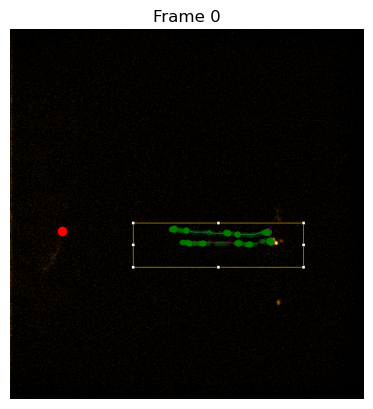

In [5]:
filepath = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/1_measurements/20240523/20240523_s01p01t01/TrackMate capture of 20240523_s01p01t01_1_5sON_15sOFF_1000mV-1.tif'

tip = df_general_info.loc[df_general_info['trackmate_file'].str.contains('20240523_s01p01t01_1_5sON_15sOFF'), ['tip_x', 'tip_y']].values[0]

df = pd.read_hdf('/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/20240523_s01p01t01_1_5sON_15sOFF_spots_extended.h5')
tracks_x = df['POSITION_X'].values
tracks_y = df['POSITION_Y'].values

# Load the time series TIFF file
images = tifffile.imread(filepath)

# Check the shape of the images array (T, Z, Y, X) or (T, Y, X) depending on the data
# Plot the first frame of the time series
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.plot(tip[0], tip[1], 'ro')
plt.plot(tracks_x/pix_size, tracks_y/pix_size, 'g.', alpha =0.2)
plt.title('Frame 0')
plt.axis('off')
plt.show()

# Calculating response parameters (model independent)

Calculating the parameters: 
- The total distance travelled during Magnet ON (rising_dif)
- Relaxation distance (relaxing_dif)
- rising_dif normalized with the average pulse force
- Relative difference between relaxing_dif and rising_dif (which is the parameter a)
  

No filtering on the data done, except for insuficient number of data points. 
  

In [6]:
dir_measurements_extended = dir_analysis+'/measurements_extended_info/'

df_results = pd.DataFrame(columns = ['exp_date', 'sample', 'position', 'embryo', 'rep', 'track_id', 'pulse_n', 'rising_dif', 'relaxing_dif', 'rising_dif_norm', 'relative_dif', 'MT_status'])

for filename in tqdm(os.listdir(dir_measurements_extended)):
    df = pd.read_hdf(dir_measurements_extended+filename, key='df')
    df = df.sort_values(by='POSITION_T')

    for track_id in df['TRACK_ID'].unique():
        track = df[df['TRACK_ID']==track_id]
        for pulse_n in track['PULSE_NUMBER'].unique():
            pulse = track[track['PULSE_NUMBER']==pulse_n]

            if not np.all(pulse['CORRECTED DISPLACEMENT [um]'].notna()):
                continue

            displacement = pulse['CORRECTED DISPLACEMENT [um]'].values
            avg_force = np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values)

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            relaxing_phase = pulse.loc[pulse['MAGNET_STATUS']==0, 'CORRECTED DISPLACEMENT [um]'].values
            
            rising_dif = rising_phase[-1]-rising_phase[0]
            relaxing_dif = relaxing_phase[-1]-relaxing_phase[0]

            rising_dif_norm = rising_dif/avg_force
            rising_dif_norm_inverse = 1/rising_dif_norm


            new_line = {
                'exp_date': [filename.split('_')[0]], 
                'sample': [filename.split('_')[1][0:3]], 
                'position': [filename.split('_')[1][3:6]], 
                'embryo': [filename.split('_')[0]+filename.split('_')[1][0:6]],
                'rep': [filename.split('_')[1][6:9]], 
                'track_id': track_id,
                'pulse_n': pulse_n,
                'avg_force': avg_force,
                'rising_dif': [rising_dif], 
                'relaxing_dif': [relaxing_dif], 
                'rising_dif_norm': [rising_dif_norm], 
                'rising_dif_norm_inverse': [rising_dif_norm_inverse],
                'relative_dif': [-relaxing_dif/rising_dif], 
                'MT_status': [pulse['MT_STATUS'].values[0]]
            }
            df_results = pd.concat([df_results, pd.DataFrame(new_line)])

if save_to_server:
    if not os.path.exists(f'{dir_plots}/results/'):
        os.makedirs(f'{dir_plots}/results/')
    df_results.to_csv(f'{dir_plots}/results/results_independent_analysis.csv', index=False)

100%|██████████| 24/24 [00:05<00:00,  4.06it/s]


In [7]:
# if (relaxing_dif < 0) and (rising_dif > 0) and (- relaxing_dif/rising_dif <= 1)
df_results.head()

,exp_date,sample,position,embryo,rep,track_id,pulse_n,rising_dif,relaxing_dif,rising_dif_norm,relative_dif,MT_status,avg_force,rising_dif_norm_inverse
0,20240621,s01,p01,20240621s01p01,t02,5,3,5.431235,-1.654144,0.144782,0.304561,n,37.513186,6.906935
0,20240621,s01,p01,20240621s01p01,t02,5,4,0.825725,0.315333,0.021826,-0.381887,n,37.831848,45.816514
0,20240621,s01,p01,20240621s01p01,t02,5,7,1.700312,-0.861260,0.043457,0.506530,n,39.126057,23.011103
0,20240621,s01,p01,20240621s01p01,t02,5,8,3.578237,0.703327,0.089441,-0.196557,n,40.006696,11.180561
0,20240621,s01,p01,20240621s01p01,t02,5,9,3.500590,-1.868374,0.085096,0.533731,n,41.136915,11.751422


   MT_status       mean        std     median         q1         q3
9          y   2.566431   1.018203   2.305833   1.777623   2.851660
10         y   1.996096   0.783695   2.028194   1.558295   2.547827
11         y   1.977281   0.873115   1.772552   1.413615   2.330365
12         y   1.965568   0.462139   1.885260   1.687994   2.336678
13         y   0.937562   0.444507   0.821198   0.645849   1.199268
14         y   3.260396   1.906181   2.363370   1.682856   5.130094
15         y   1.768510   0.951771   1.617440   1.287167   2.290217
0          n  15.585988  10.261518  12.331136   5.953838  23.402815
1          n  18.835413  11.522869  17.029835  11.231340  24.633908
2          n   5.081177   4.918184   3.500590   1.700312   6.000503
3          n   5.812955   3.293252   4.355140   3.452634   9.484983
4          n   8.487229   7.745493   5.938106   2.473310  12.221283
5          n  15.139946   7.950828  12.839982  11.033832  15.475166
6          n  12.363370  12.988975   6.009799   

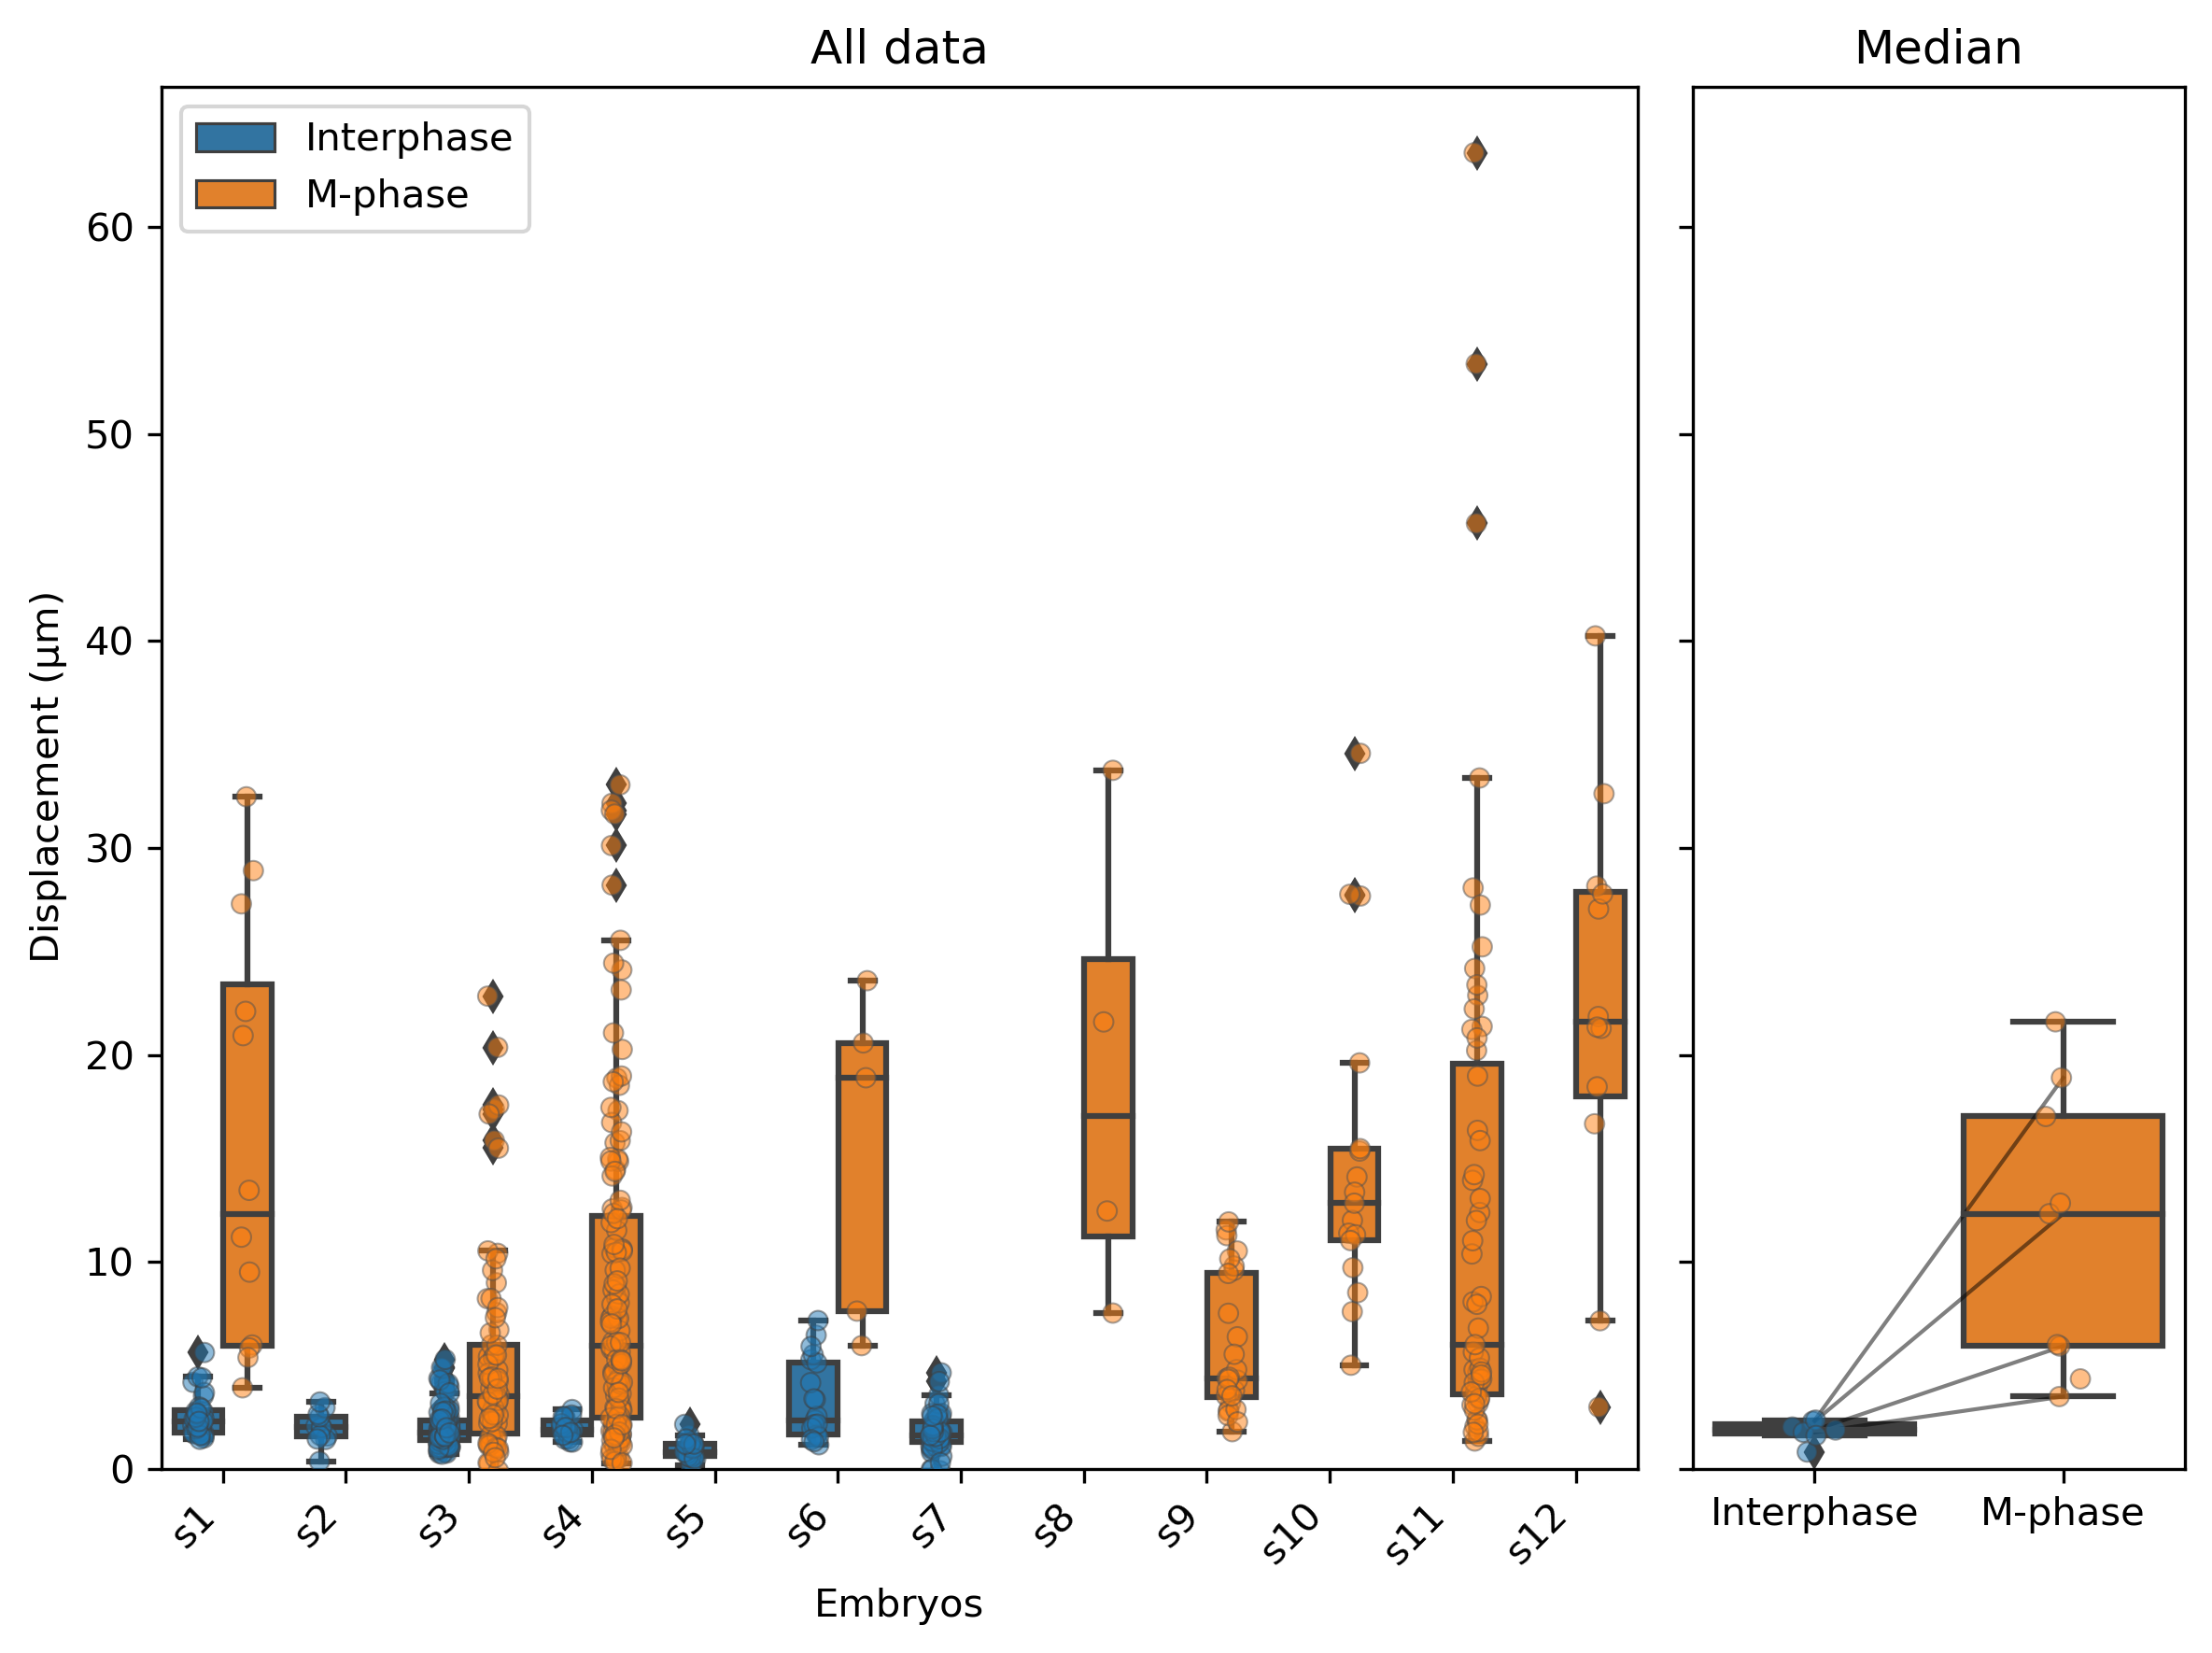

   MT_status      mean       std    median        q1        q3
9          y -0.990366  0.335708 -1.038902 -1.196775 -0.790282
10         y -0.953414  0.399119 -1.048613 -1.170471 -0.924883
11         y -0.732205  0.364891 -0.700660 -0.945788 -0.491602
12         y -0.792156  0.268162 -0.713391 -1.015514 -0.635040
13         y -0.536841  0.223538 -0.474962 -0.710838 -0.351826
14         y -0.834038  0.553860 -0.653885 -1.200416 -0.535272
15         y -0.776070  0.441010 -0.778511 -1.133163 -0.487689
0          n -2.202714  1.063554 -1.637448 -2.641158 -1.364401
1          n -1.396338  0.908316 -0.960087 -1.424228 -0.932198
2          n -0.883107  0.571112 -0.864560 -1.256836 -0.610698
3          n -1.052451  0.363333 -1.014292 -1.362504 -0.803210
4          n -0.921576  0.660361 -0.868042 -1.363503 -0.469074
5          n -1.301648  0.478000 -1.234176 -1.627115 -0.926974
6          n -1.195623  0.619105 -1.134890 -1.568446 -0.756477
7          n -1.967690  0.921864 -1.944555 -2.727816 -1

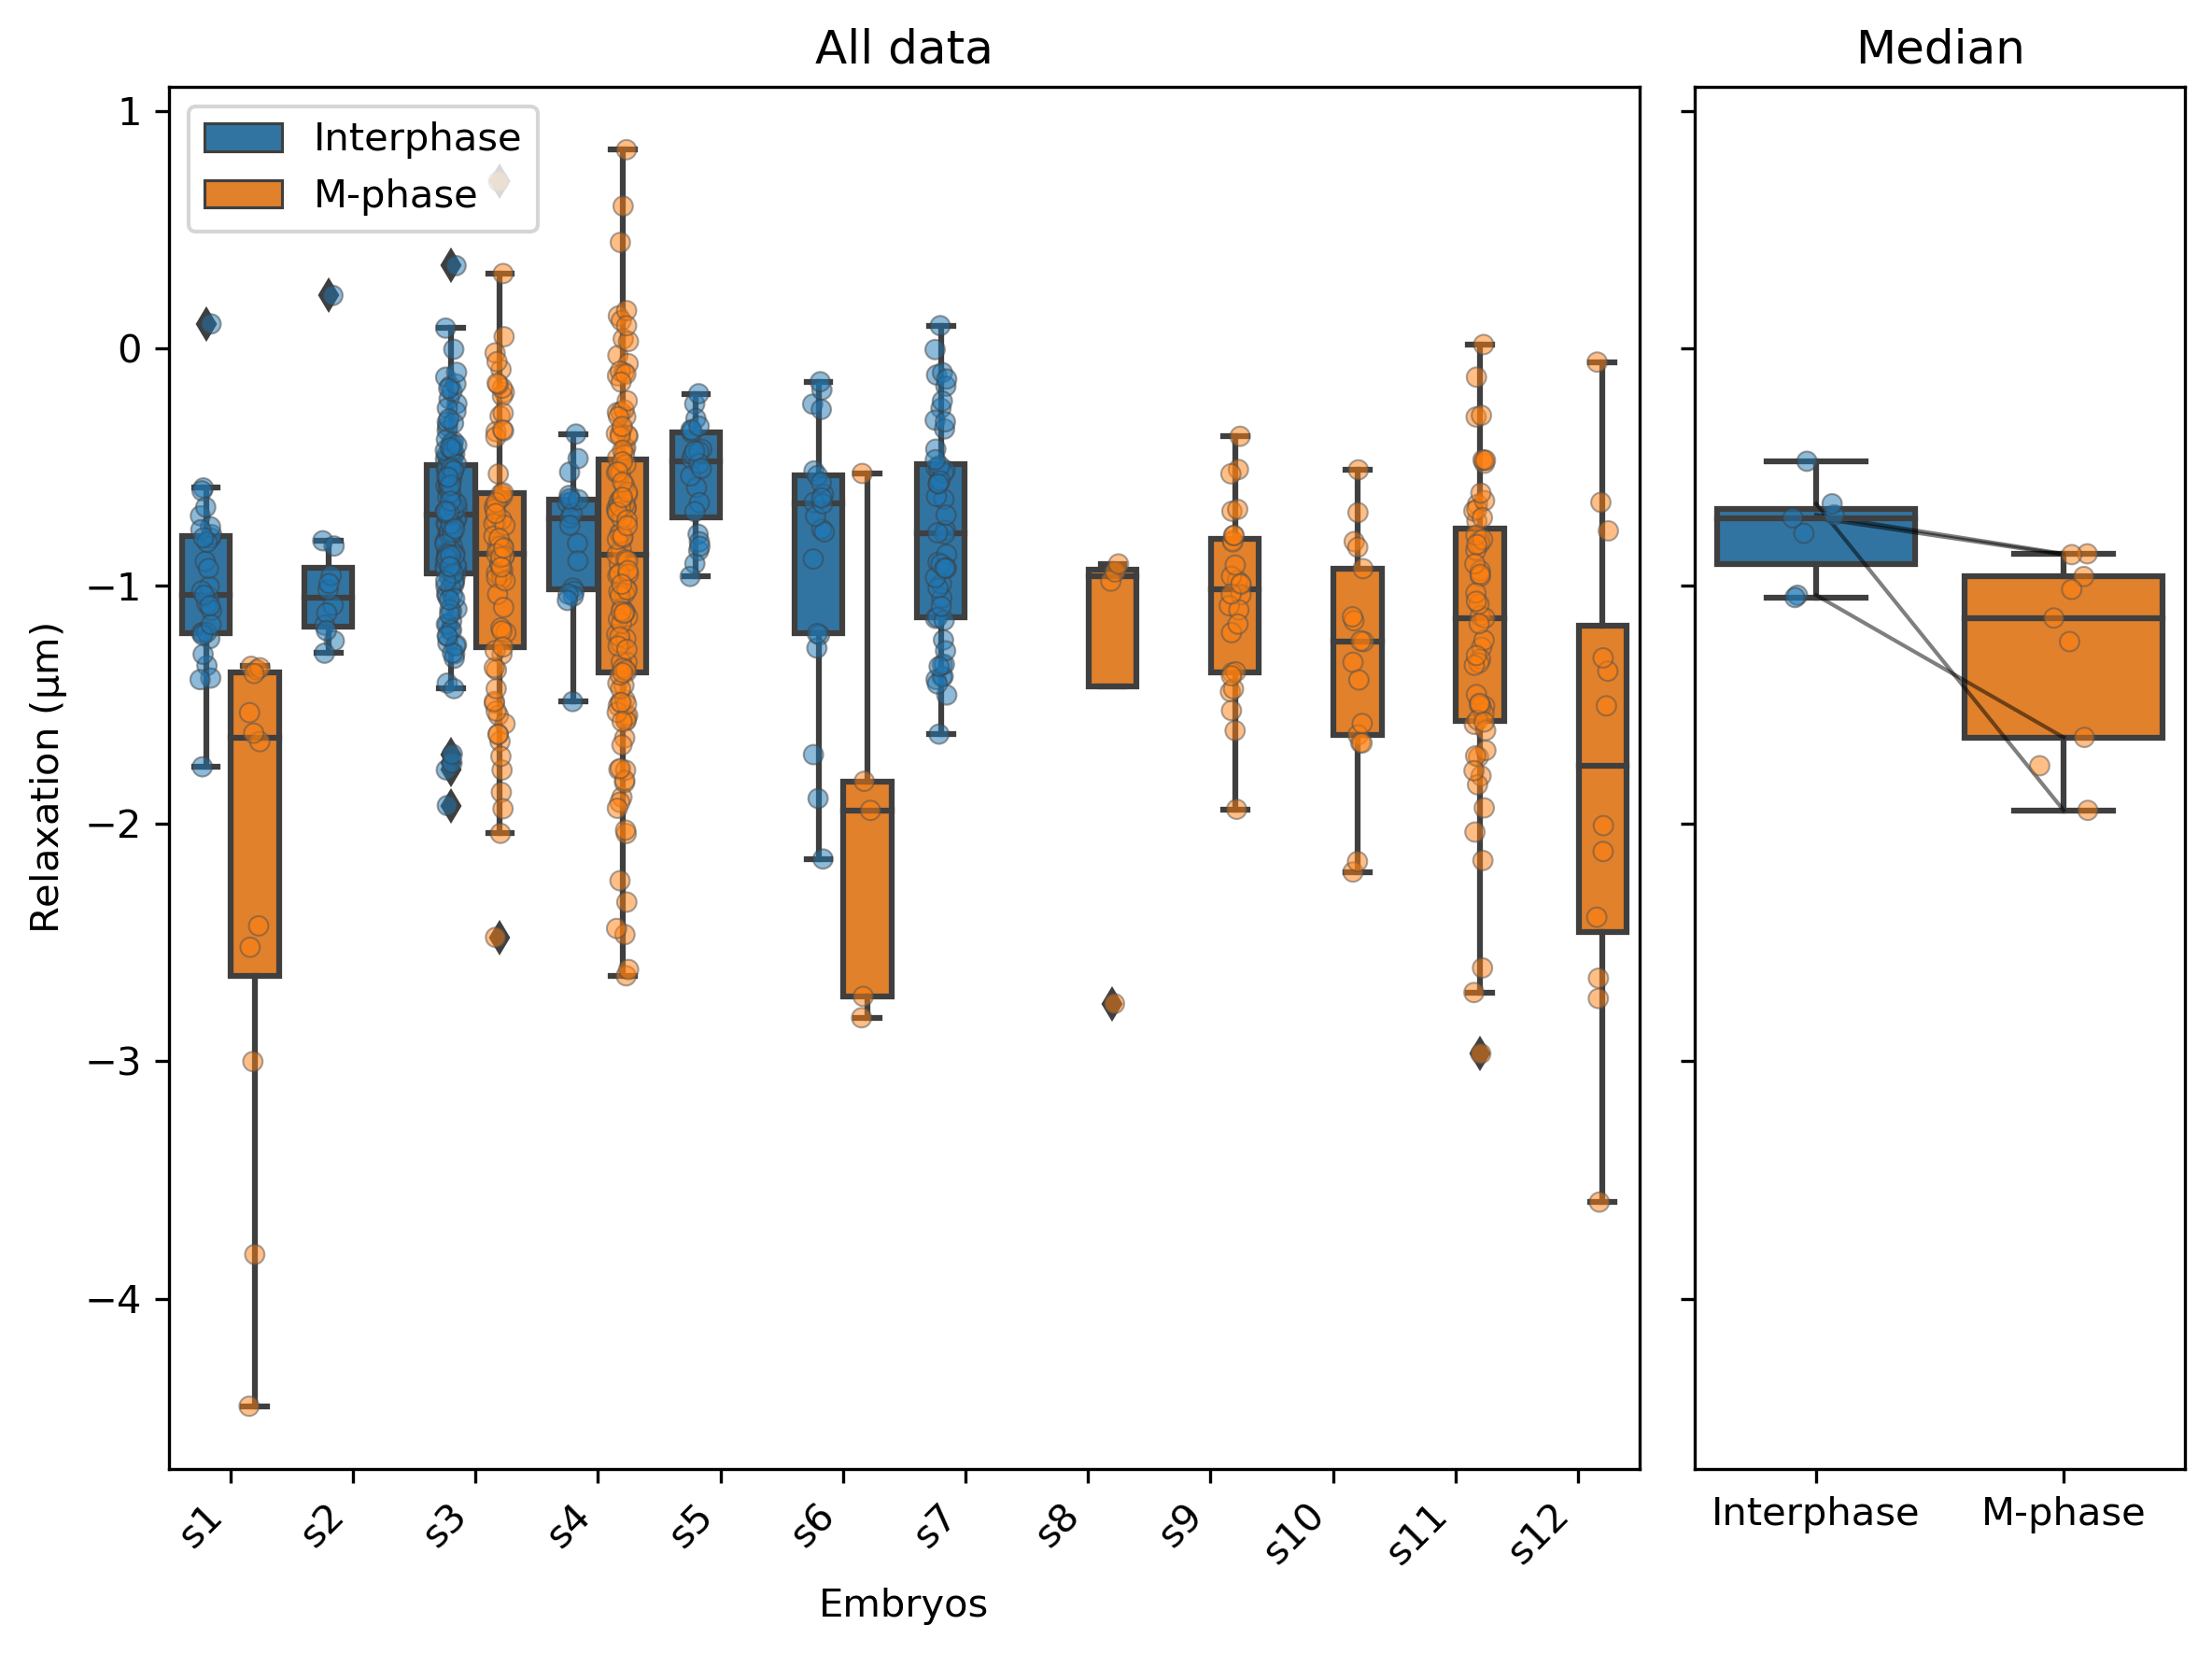

   MT_status      mean       std    median        q1        q3
9          y  0.077449  0.028150  0.067713  0.055960  0.090103
10         y  0.045298  0.017113  0.047257  0.036175  0.057428
11         y  0.049177  0.021839  0.045073  0.034028  0.058056
12         y  0.036176  0.008371  0.035800  0.029170  0.042174
13         y  0.036430  0.016732  0.033138  0.025788  0.045606
14         y  0.123411  0.077304  0.093061  0.053495  0.202590
15         y  0.038997  0.020715  0.037172  0.027412  0.048649
0          n  0.178830  0.125797  0.145211  0.094076  0.212548
1          n  0.228203  0.174546  0.223145  0.083747  0.367601
2          n  0.090618  0.087595  0.061507  0.026923  0.114783
3          n  0.111118  0.065254  0.085104  0.064105  0.166389
4          n  0.157101  0.141522  0.111386  0.044469  0.245462
5          n  0.323978  0.188130  0.242713  0.218192  0.368489
6          n  0.269178  0.239514  0.158480  0.074441  0.486000
7          n  0.235242  0.083238  0.246632  0.222608  0

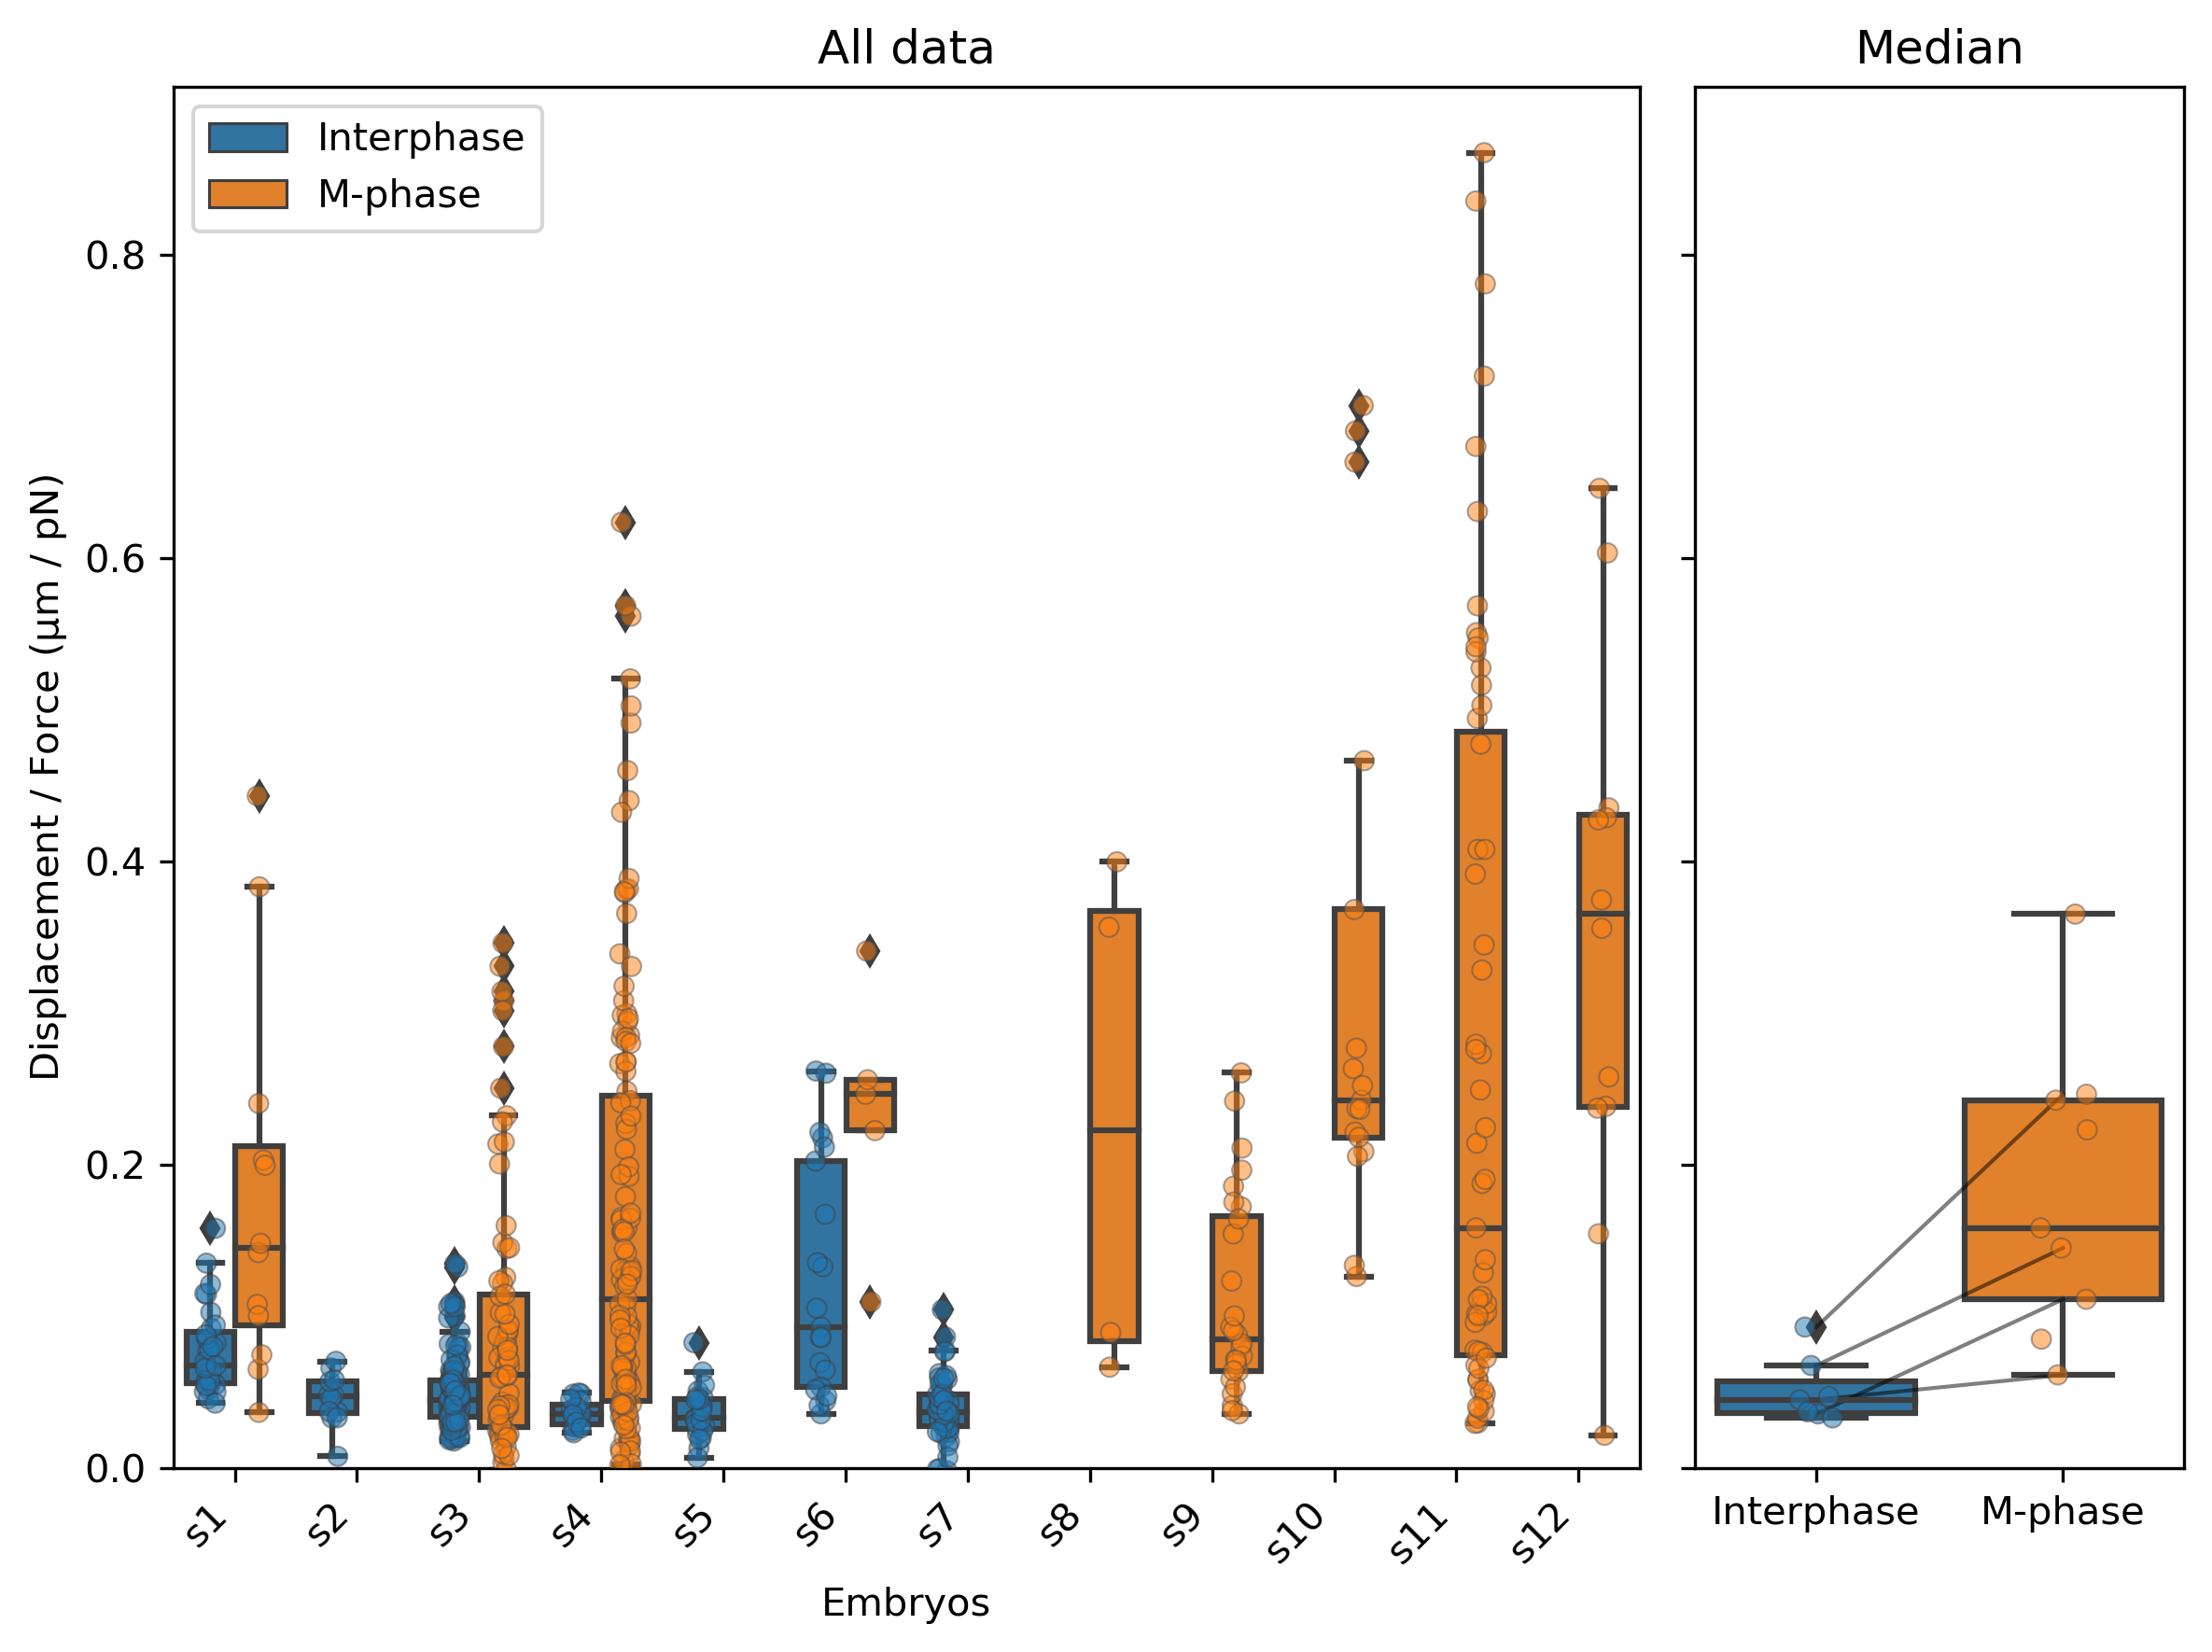

   MT_status       mean         std     median         q1         q3
9          y  14.378510    4.439034  14.768224  11.104541  17.870527
10         y  30.776164   31.242058  21.169912  17.414476  27.706546
11         y  24.155371   10.178130  22.186414  17.224712  29.387569
12         y  29.122008    6.914890  27.933258  23.774922  34.333840
13         y  36.169561   27.043759  30.181413  21.929578  38.812621
14         y  12.105376    7.562019  10.745630   4.936082  18.693254
15         y -79.515464  527.834543  26.288000  18.054220  33.331998
0          n   8.988195    7.025150   6.889574   4.730004  10.805445
1          n   7.874266    6.232318   6.989996   2.726982  12.137280
2          n  14.853759  128.370193  14.887101   8.195855  35.276303
3          n  12.319253    6.746283  11.765394   6.012562  15.599563
4          n  23.266322   52.946367   8.977821   4.074620  22.506375
5          n   3.959552    1.836918   4.120088   2.713785   4.583127
6          n   9.424797    8.86526

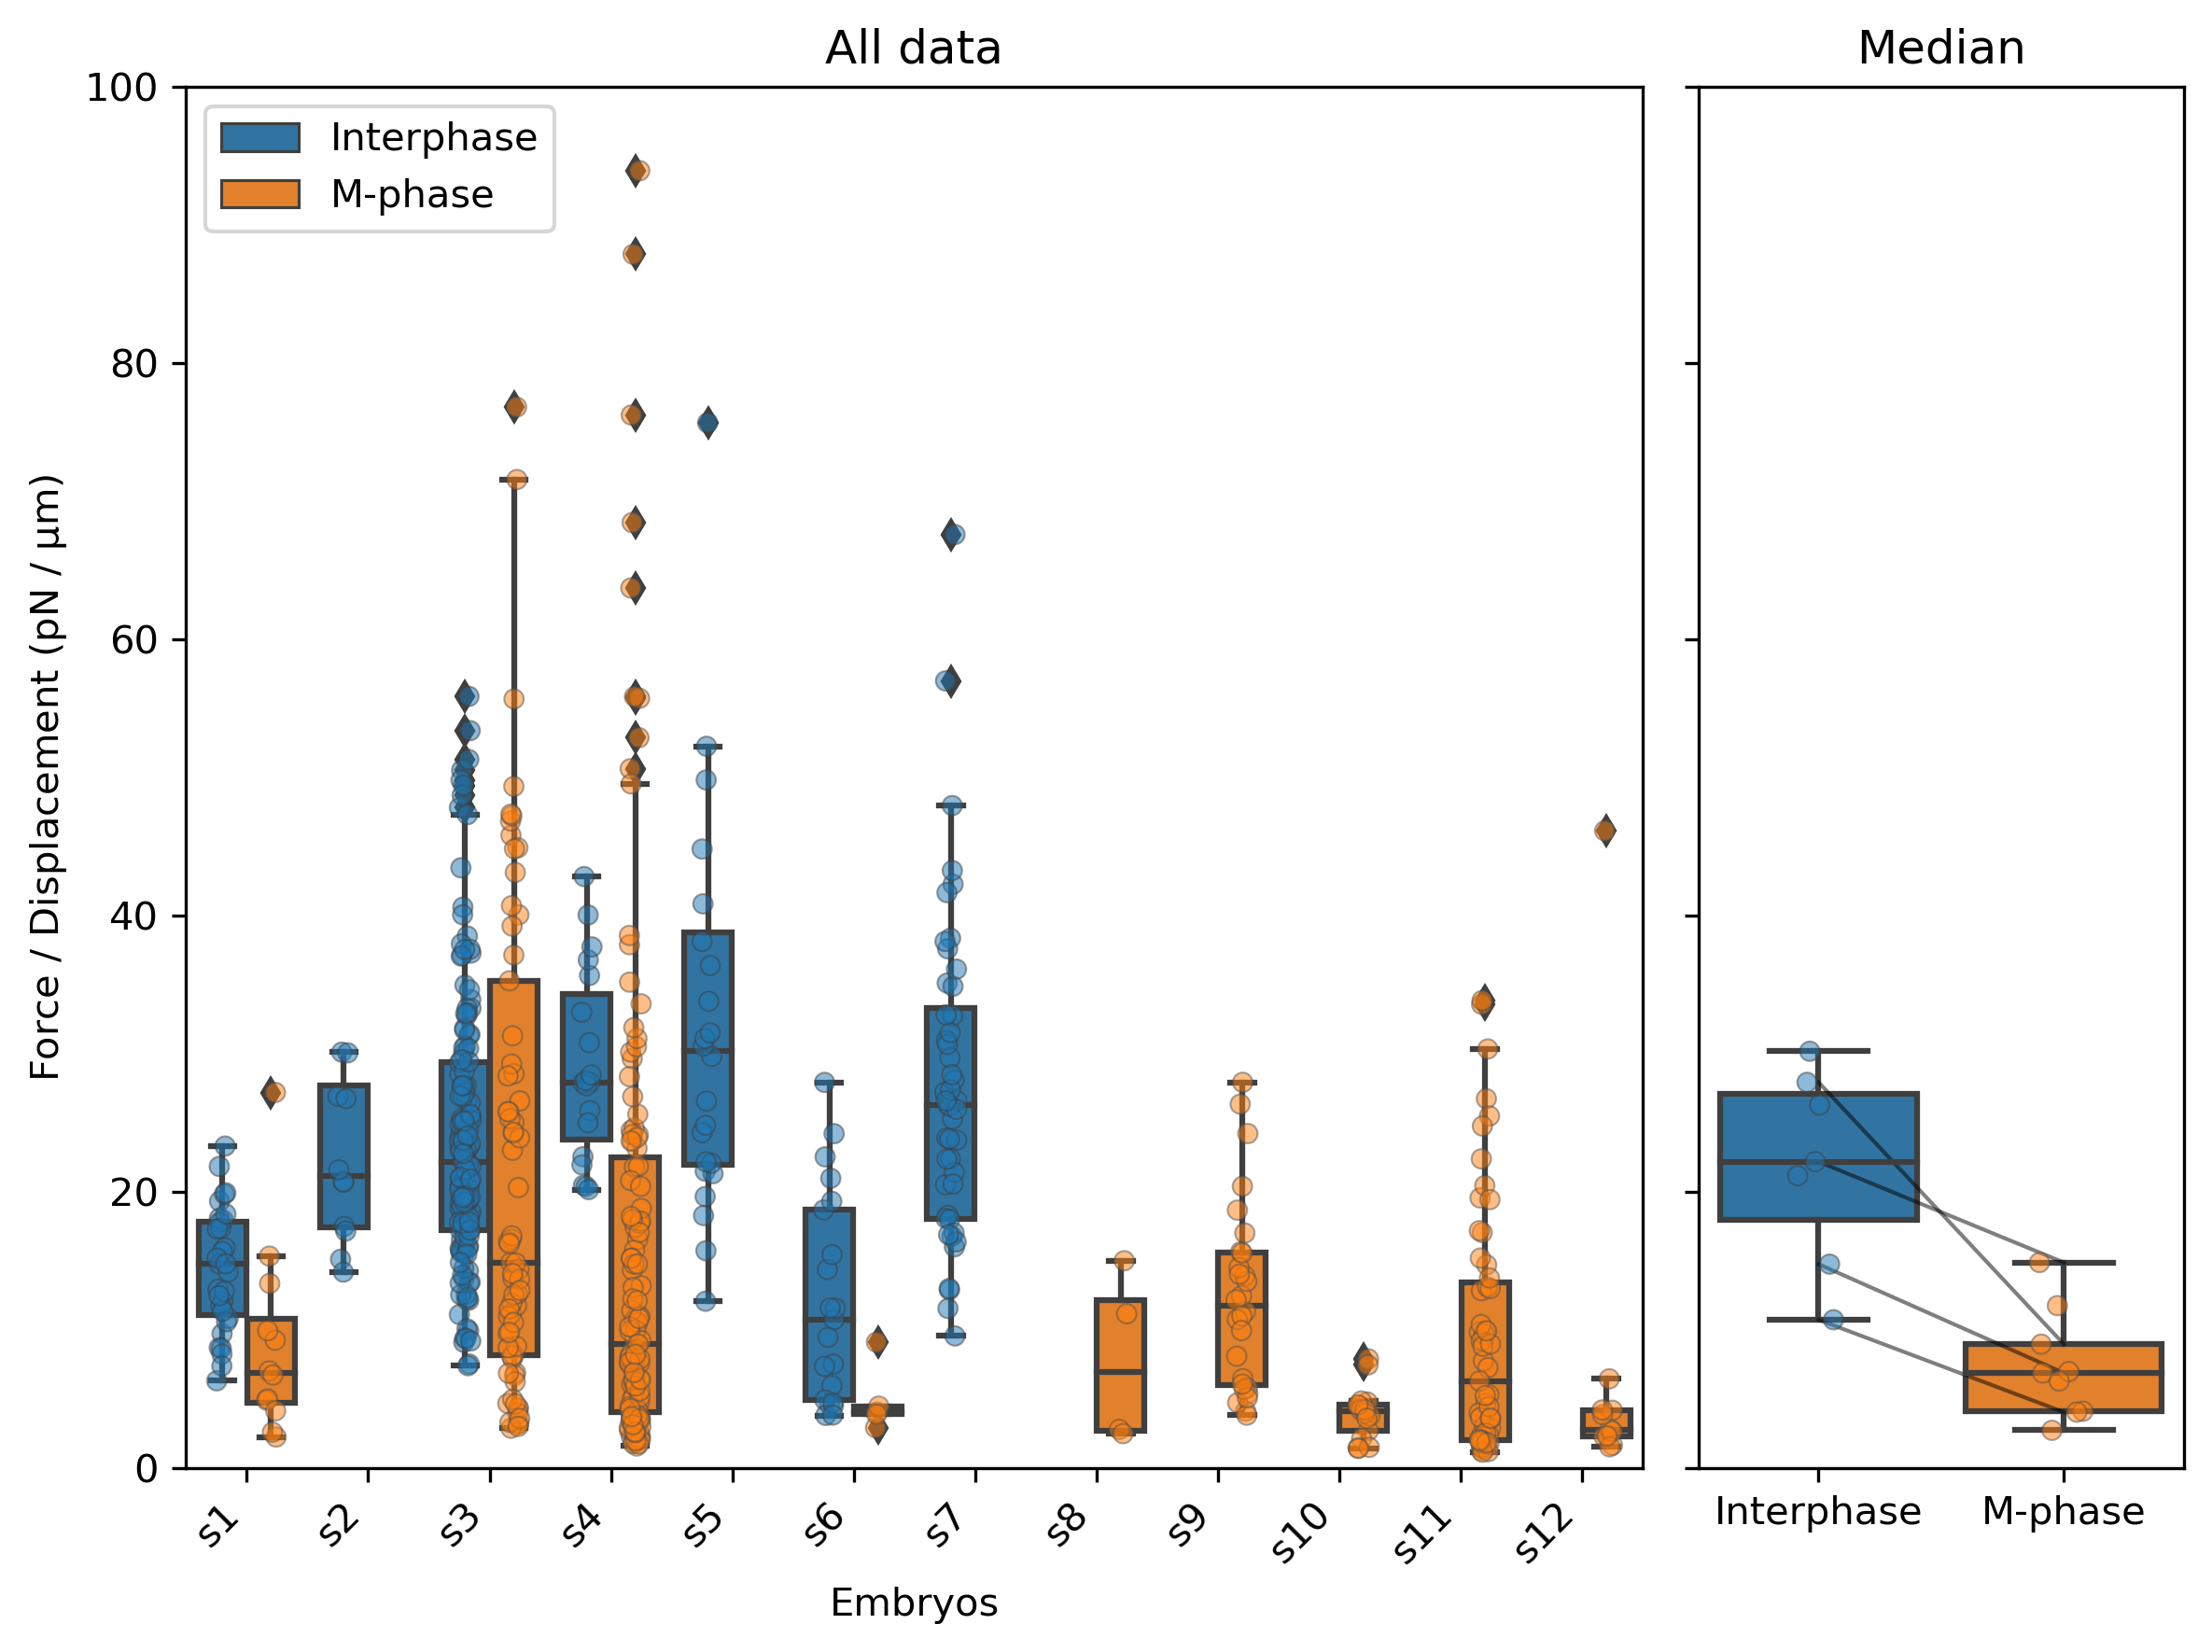

   MT_status      mean       std    median        q1        q3
9          y  0.439997  0.189918  0.401405  0.338893  0.560289
10         y  0.430261  0.354686  0.463730  0.395291  0.572178
11         y  0.413621  0.230335  0.388506  0.251130  0.546876
12         y  0.418623  0.148437  0.413304  0.318623  0.508839
13         y  0.762528  0.708415  0.598530  0.406116  0.831770
14         y  0.360370  0.354829  0.309270  0.149735  0.358610
15         y  0.096957  2.064231  0.444316  0.271367  0.664246
0          n  0.208342  0.142612  0.184876  0.086129  0.298147
1          n  0.088591  0.047056  0.098811  0.061840  0.125562
2          n  0.295193  1.376312  0.230988  0.089093  0.506530
3          n  0.220806  0.104204  0.225899  0.126840  0.279326
4          n  0.288354  0.396648  0.139118  0.066740  0.289032
5          n  0.111319  0.073175  0.092317  0.081939  0.150805
6          n  0.208641  0.192745  0.133592  0.064042  0.328081
7          n  0.194943  0.177346  0.144334  0.077246  0

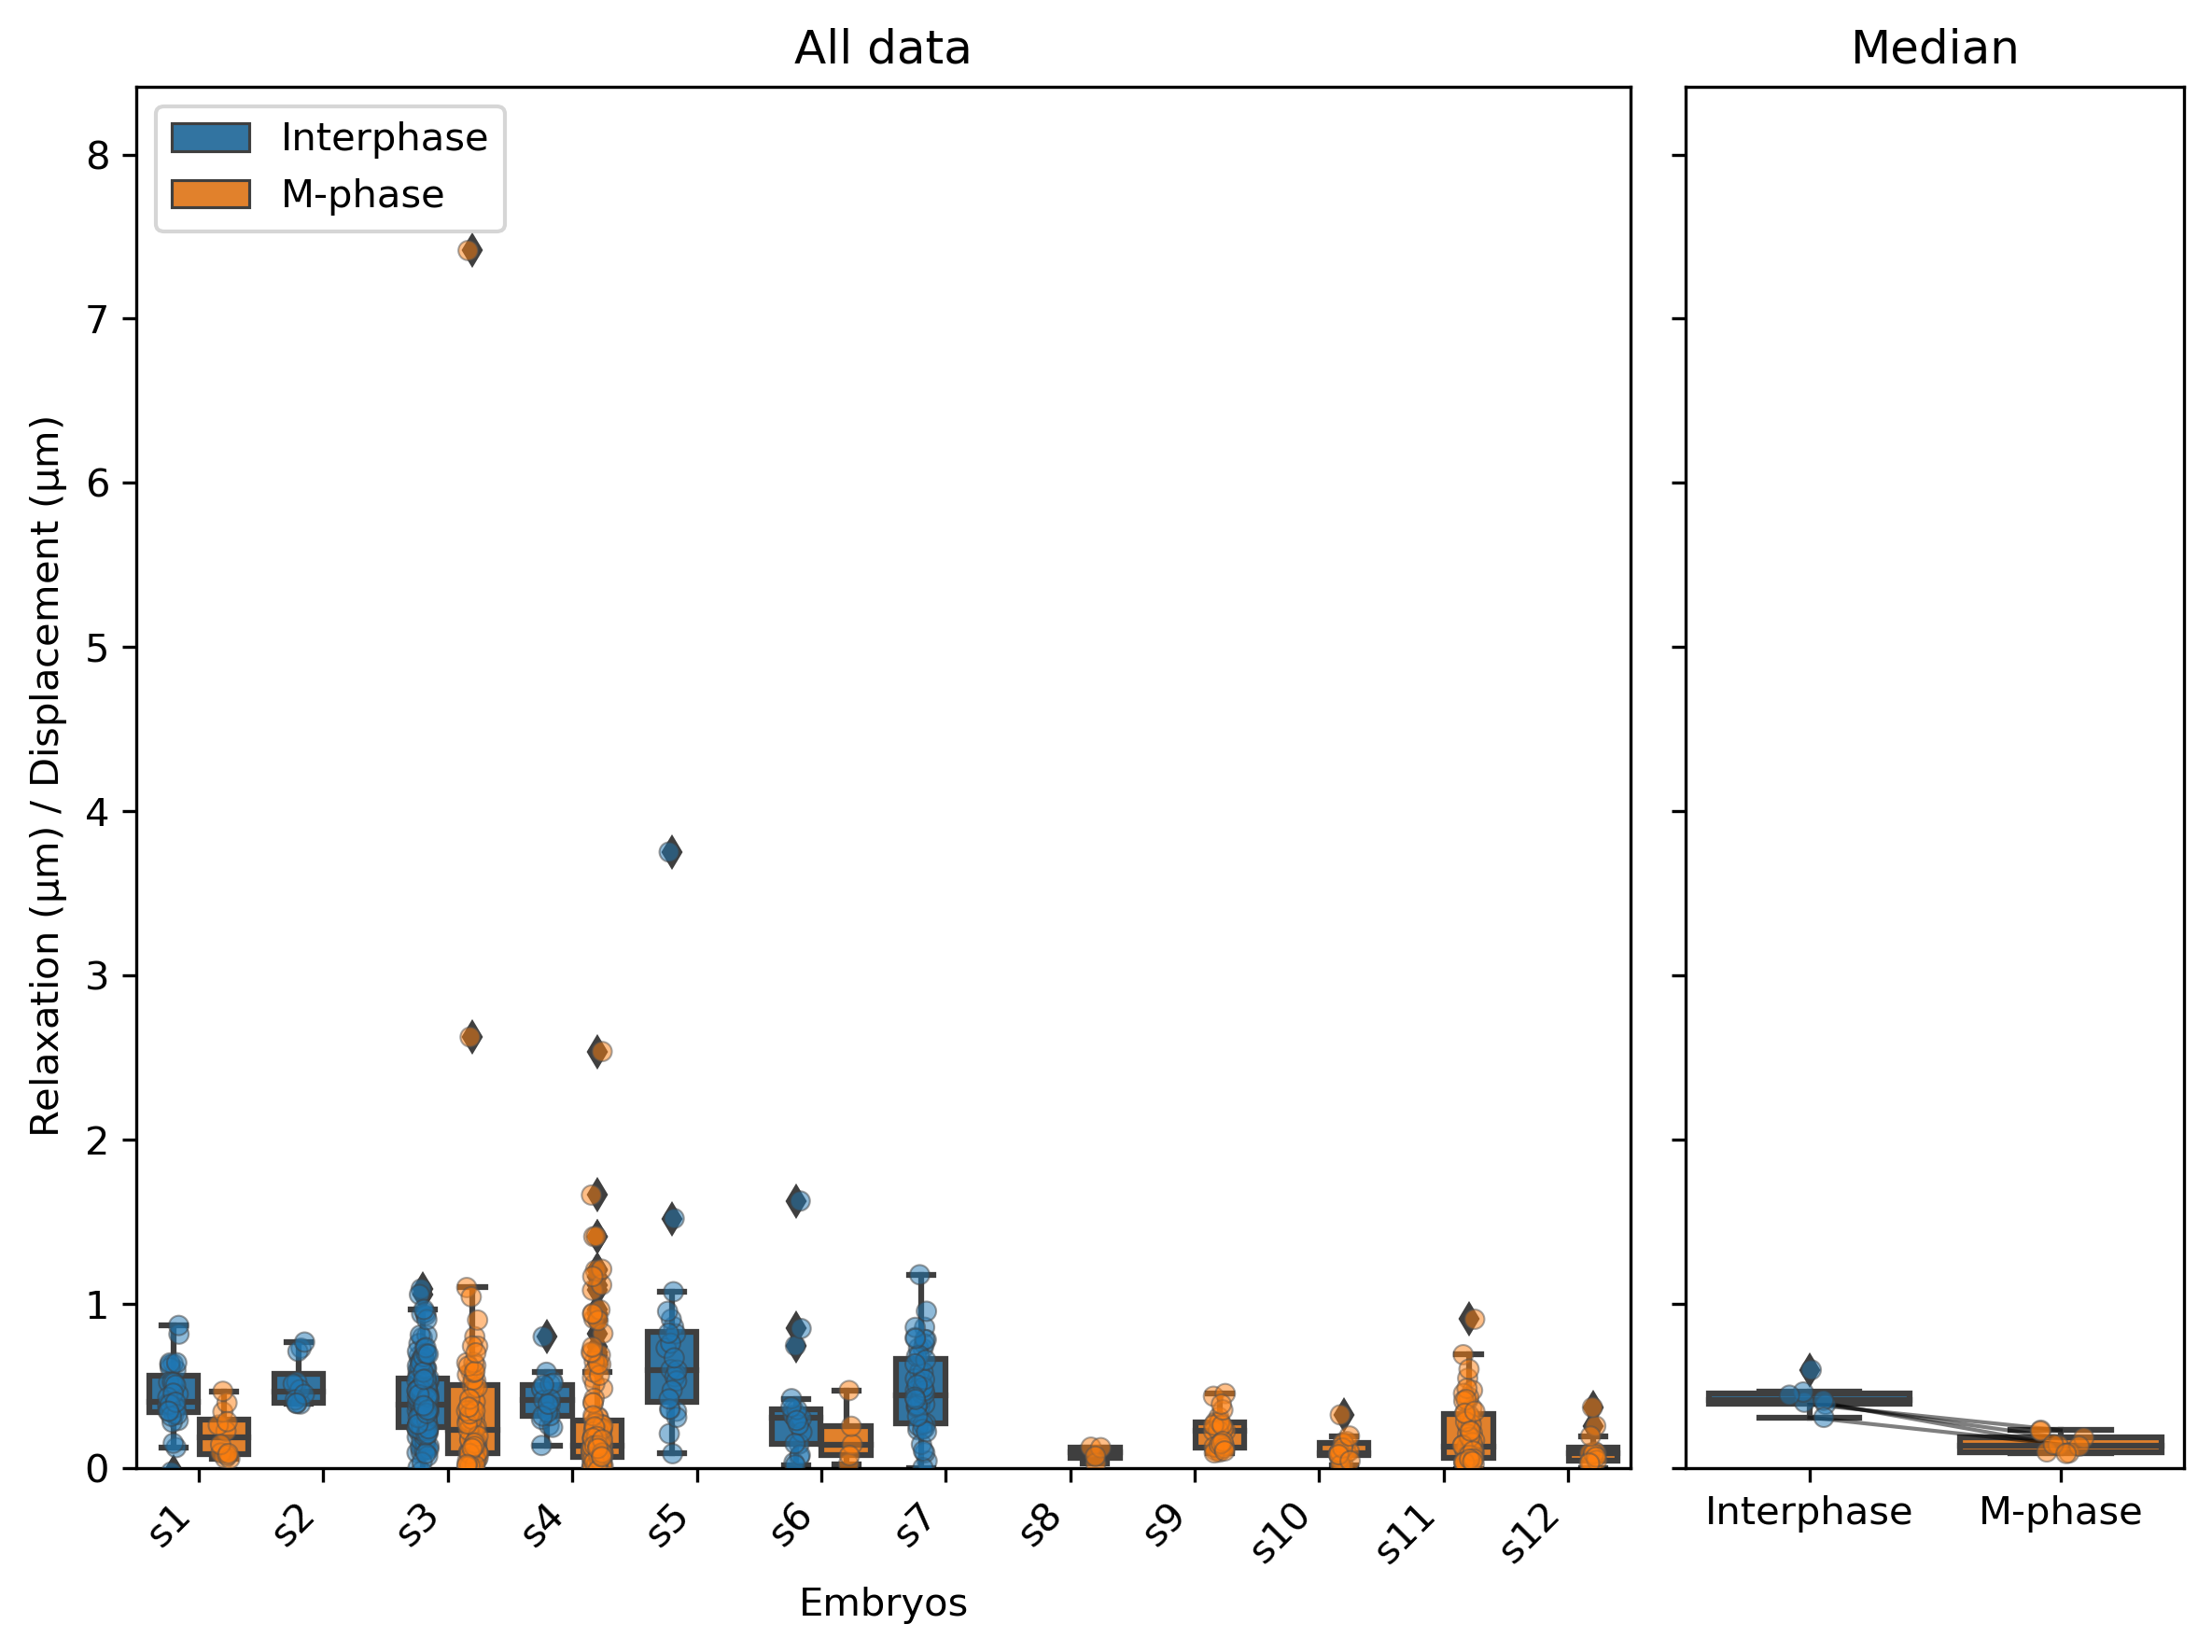

In [9]:
df_results = df_results.sort_values(by=['MT_status', 'embryo'], ascending=[False, True])
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)

df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

params = ['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif']
labels = ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement (pN / $\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$) / Displacement ($\mathrm{\\mu m}$)']

df = df_results
for (param, label) in zip(params, labels):
    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 6), dpi=300, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

    # First subplot: Combined boxplot and stripplot
    sns.boxplot(ax=axes[0], x='embryo', y=param, hue='Phase', data=df)
    sns.stripplot(ax=axes[0], x='embryo', y=param, hue='Phase', dodge=True, data=df, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[0].set_xticks(ticks=range(len(df['embryo'].unique())))
    axes[0].set_xticklabels(labels=['s' + str(i+1) for i in range(len(df['embryo'].unique()))], rotation=45, ha='right')
    axes[0].set_ylabel(label)
    axes[0].set_xlabel('Embryos')

    # Add custom legend to the first plot
    axes[0].legend(loc='upper left')
    axes[0].set_title('All data')

    # Second subplot: Summary statistics
    sns.boxplot(ax=axes[1], x='MT_status', y='median', data=stats)
    sns.stripplot(ax=axes[1], x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    axes[1].set_xticklabels(labels=['Interphase', 'M-phase'])
    axes[1].set_title(f'Median')

     # Calculate statistics
    stats_ = stats.drop(columns=['embryo'])
    print(stats_)
    stats_of_stats = stats_[['MT_status', 'median']].groupby(['MT_status']).agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats_of_stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats_of_stats['parameter'] = param
    stats_of_stats = stats_of_stats.reset_index()
    stats_of_stats = stats_of_stats.sort_values(by='MT_status', ascending=False)
    print(stats_of_stats)
    
    df_median_stats = pd.concat([df_median_stats, stats_of_stats])

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            axes[1].plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    # Show the plots
    if param != 'relaxing_dif':
        plt.ylim(bottom=0)
    if param == 'rising_dif_norm_inverse':
        plt.ylim(top=100)
    plt.tight_layout()

    if save_to_server:
        plt.savefig(f'{dir_plots}/results/result_{param}.svg', format='svg')
    plt.show()

In [11]:
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity median'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values) # in Pa.s median(eff_viscosity) = dt/(6*pi*r*median(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity mean'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'mean'].values) # in Pa.s mean(eff_viscosity) = dt/(6*pi*r*mean(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q1'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q1'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q3'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q3'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity std'] = np.multiply(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'std'].values, np.divide(5/(6*np.pi*1.4),np.square(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values))) # in Pa.s std(eff_viscosity) = std(rising_dif_norm)*dt/(6*pi*r*median(rising_dif_norm)**2)

if save_to_server:
    df_median_stats.to_csv(f'{dir_plots}/results/results_simple_analysis_stats_of_median.csv')

for (i, embryo) in enumerate(df['embryo'].unique()):
    print(embryo, f's{i}')
    print('Interphase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='Interphase')]))
    print('M-phase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='M-phase')]))

df = df.sort_values(by='embryo',ascending=False)
for embryo in df['embryo'].unique():
    print(embryo)
    print(df.loc[df['embryo']==embryo, 'MT_status'].unique())

20240523s02p01 s0
Interphase
N =  31
M-phase
N =  12
20240614s02p02 s1
Interphase
N =  12
M-phase
N =  0
20240621s01p01 s2
Interphase
N =  147
M-phase
N =  77
20240621s02p02 s3
Interphase
N =  19
M-phase
N =  135
20240705s01p01 s4
Interphase
N =  24
M-phase
N =  0
20240705s02p01 s5
Interphase
N =  21
M-phase
N =  5
20240711s01p01 s6
Interphase
N =  52
M-phase
N =  0
20240618s01p02 s7
Interphase
N =  0
M-phase
N =  4
20240621s02p01 s8
Interphase
N =  0
M-phase
N =  28
20240703s02p01 s9
Interphase
N =  0
M-phase
N =  17
20240703s03p01 s10
Interphase
N =  0
M-phase
N =  59
20240705s03p01 s11
Interphase
N =  0
M-phase
N =  12
20240711s01p01
['y']
20240705s03p01
['n']
20240705s02p01
['n' 'y']
20240705s01p01
['y']
20240703s03p01
['n']
20240703s02p01
['n']
20240621s02p02
['n' 'y']
20240621s02p01
['n']
20240621s01p01
['n' 'y']
20240618s01p02
['n']
20240614s02p02
['y']
20240523s02p01
['y' 'n']


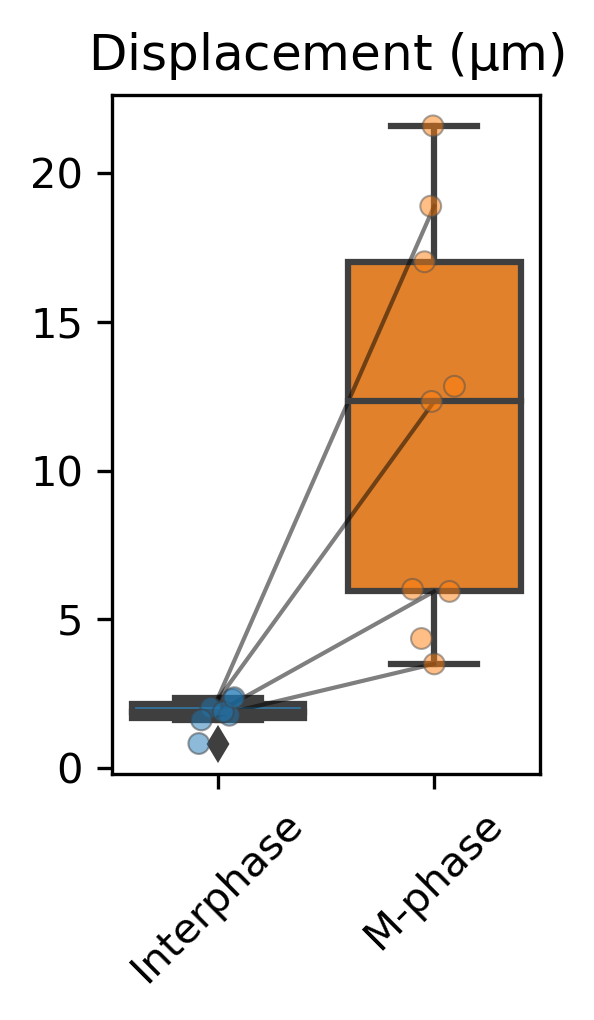

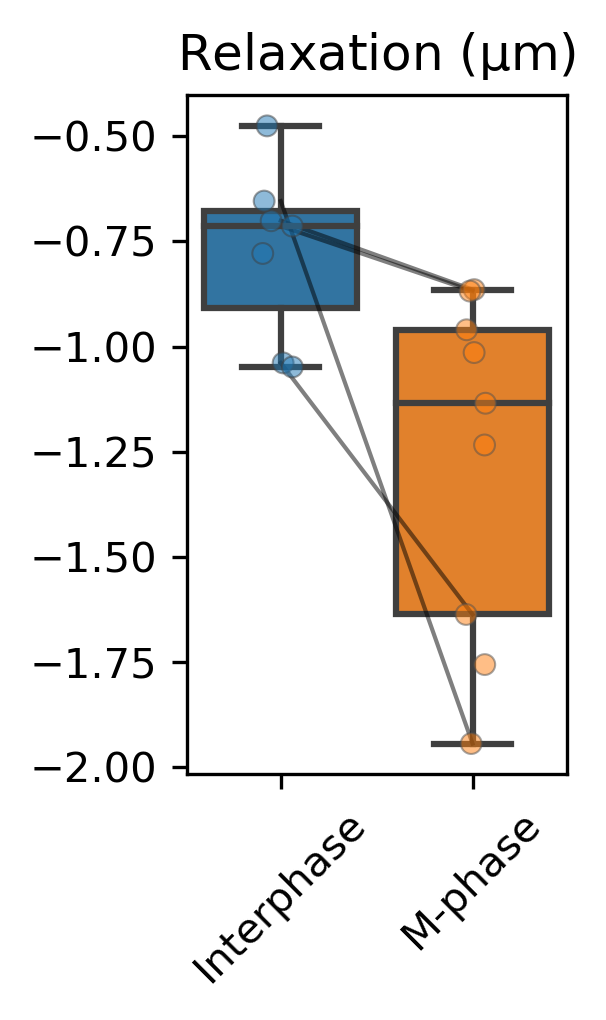

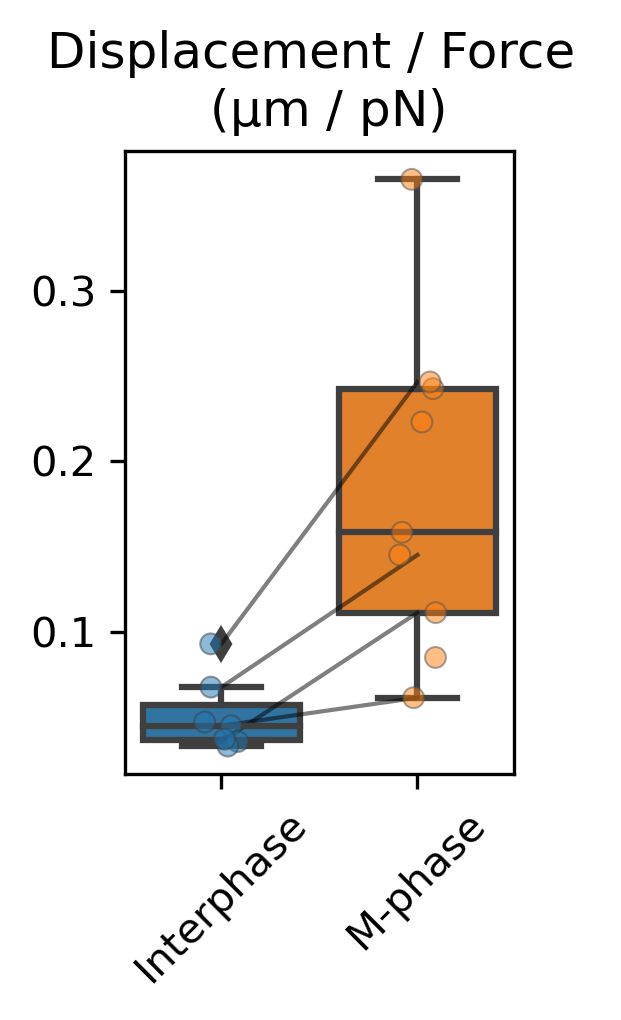

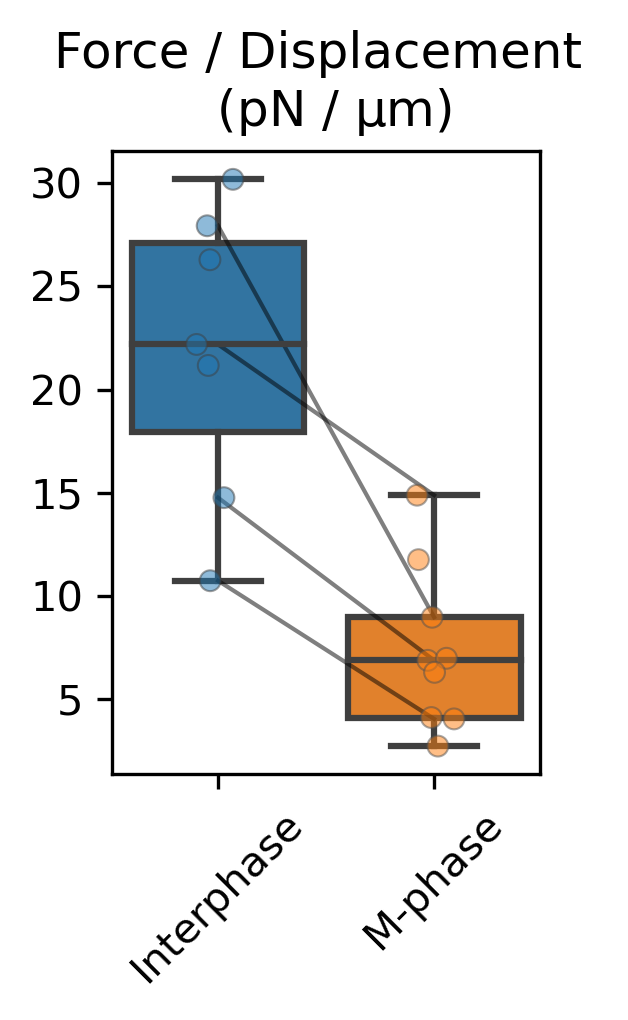

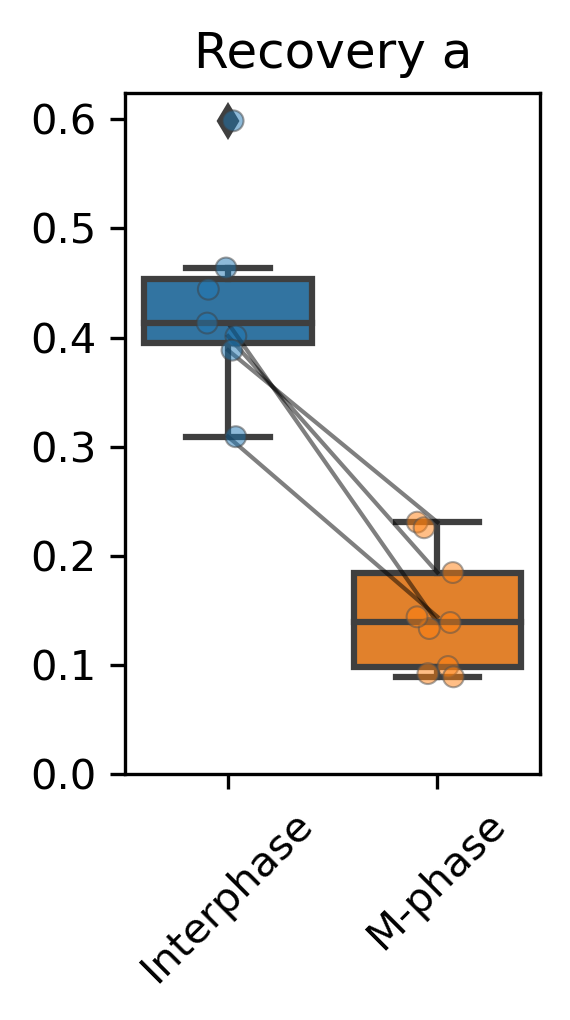

In [12]:
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)


df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force \n ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement \n (pN / $\mathrm{\\mu m}$)', 'Recovery a']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)
    

    # Create subplots
    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    # Second subplot: Summary statistics
    sns.boxplot(x='MT_status', y='median', data=stats)
    sns.stripplot(x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    plt.title(f'{label}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            plt.plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    if param == 'rising_dif_norm':
        pass
    elif param == 'relative_dif':
        plt.ylim(bottom=0)
    
    
    plt.tight_layout()
    if save_to_server:
        plt.savefig(f'{dir_plots}/results/result_{param}_modelindependent_median.svg', format='svg')
    plt.show()

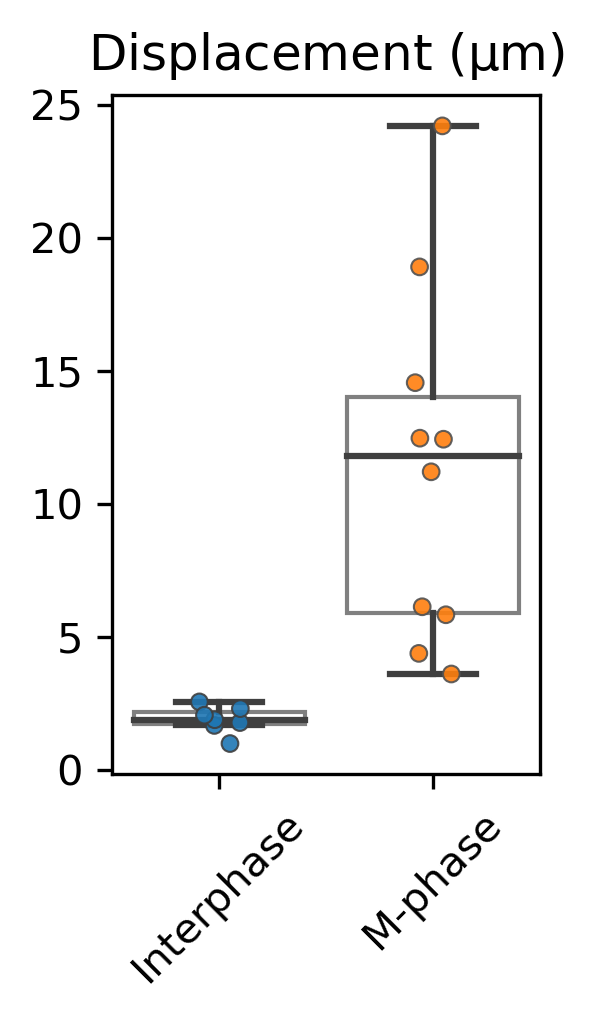

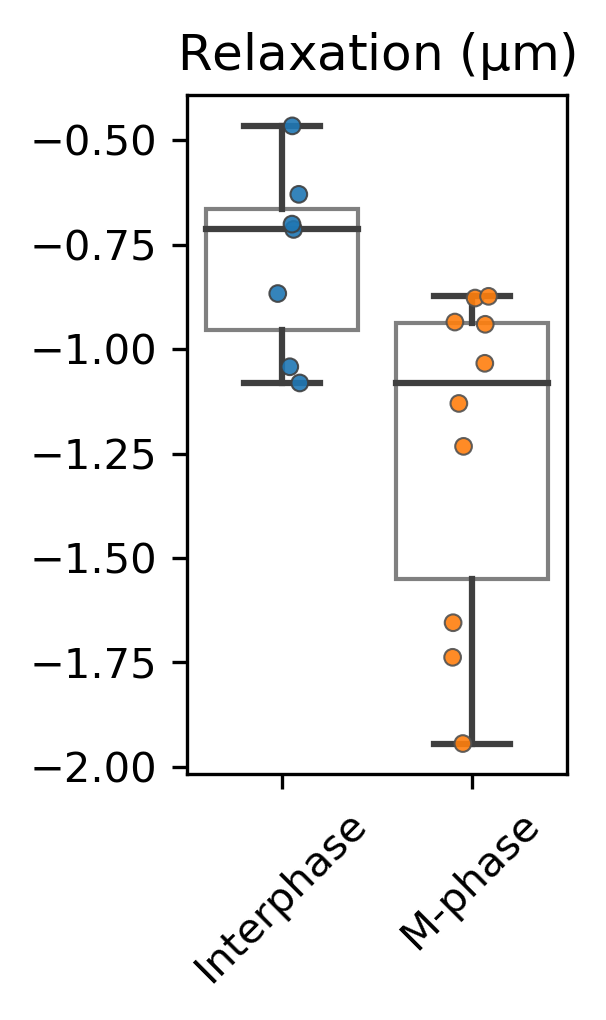

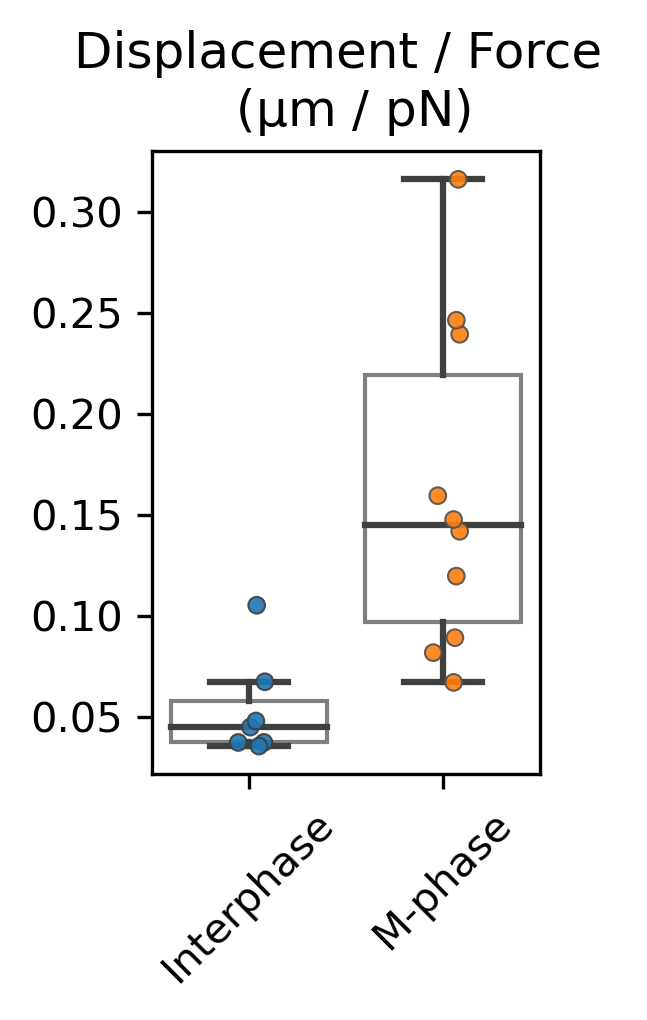

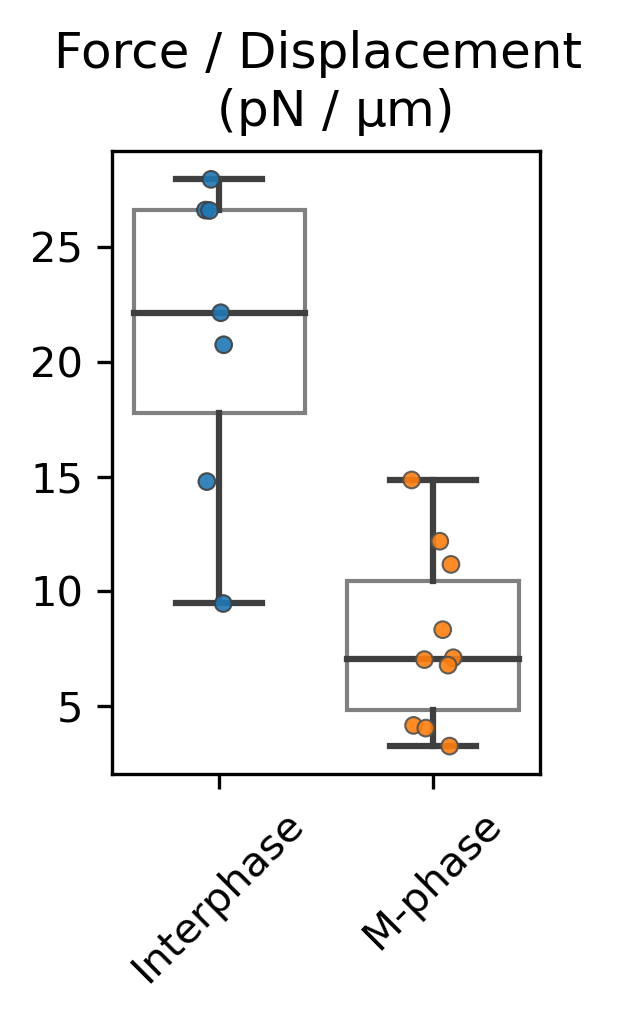

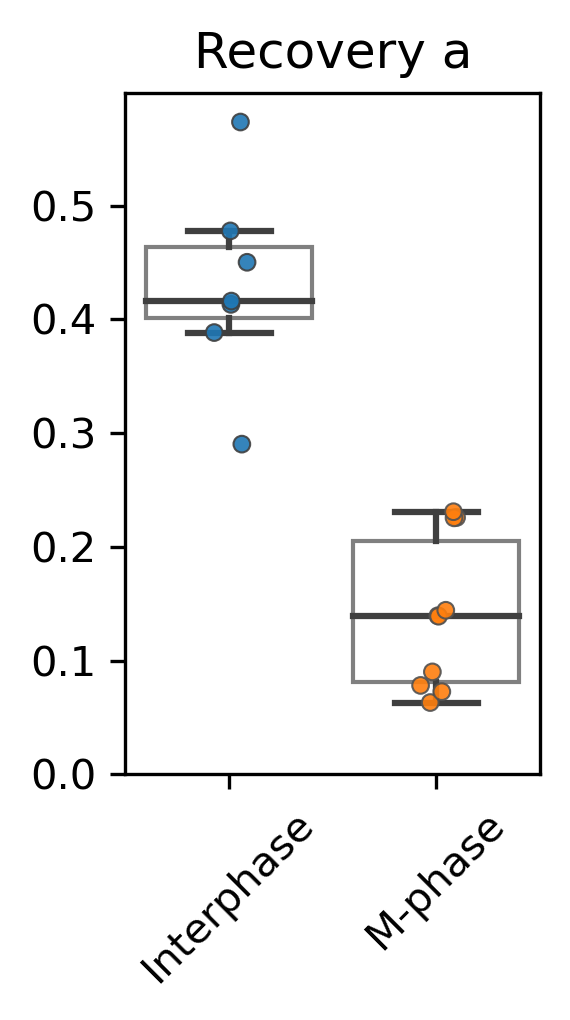

In [ ]:
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)


df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force \n ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement \n (pN / $\mathrm{\\mu m}$)', 'Recovery a']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)
    

    # Create subplots
    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    # Second subplot: Summary statistics
    boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)
    sns.boxplot(x='MT_status', y='median', data=stats, boxprops=boxprops, fliersize=0)
    sns.stripplot(x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.9, linewidth=0.5, legend=False, size=4)
    plt.title(f'{label}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)

    # for embryo in stats['embryo'].unique():
    #     if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
    #         plt.plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    if param == 'rising_dif_norm':
        pass
    elif param == 'relative_dif':
        plt.ylim(bottom=0)
    
    
    plt.tight_layout()
    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}_modelindependent_median_v2.svg', format='svg')
    plt.show()